In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load dataset
df = pd.read_csv('review_data.csv')

# Display the first few rows of the dataset
print(df.head())

# Check the distribution of sentiment labels
print(df['sentiment'].value_counts())

                                              review sentiment
0  The movie was a disappointment. The story was ...  negative
1  I absolutely loved the film. The special effec...  positive
2  Amazing movie! The plot was very engaging and ...  negative
3  Very disappointing. The movie lacked any real ...   neutral
4  An incredible movie with a great cast and wond...  positive
positive    3462
negative    3302
neutral     3235
Name: sentiment, dtype: int64


In [9]:
# Calculate the length of each review
df['review_length'] = df['review'].apply(len)

# Remove reviews that are shorter than 20 characters
df = df[df['review_length'] >= 20]

# Display the updated dataset
print(df.head())

                                              review sentiment  review_length
0  The movie was a disappointment. The story was ...  negative             67
1  I absolutely loved the film. The special effec...  positive             64
2  Amazing movie! The plot was very engaging and ...  negative             68
3  Very disappointing. The movie lacked any real ...   neutral             70
4  An incredible movie with a great cast and wond...  positive             67


In [10]:
# Encode target variable
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Display the first few rows to check the encoded labels
print(df[['sentiment', 'sentiment_encoded']].head())

  sentiment  sentiment_encoded
0  negative                  0
1  positive                  2
2  negative                  0
3   neutral                  1
4  positive                  2


In [11]:
# Split data into features (X) and target (y)
X = df['review']
y = df['sentiment_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),  # TF-IDF Vectorization with unigrams and bigrams
    ('clf', MultinomialNB())  # Naive Bayes classifier
])

In [13]:
# Perform cross-validation and print the accuracy
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Cross-Validation Accuracy: 0.3409 ± 0.0078


In [14]:
# Define the hyperparameters to tune
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams, Bigrams
    'clf__alpha': np.linspace(0.5, 2.0, 10)  # Smoothing parameter for Naive Bayes
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'clf__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}


In [15]:
# Use the best model to predict the test set
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

# Print the accuracy on the test set
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.3165
Classification Report:
               precision    recall  f1-score   support

    negative       0.31      0.26      0.28       660
     neutral       0.29      0.23      0.26       647
    positive       0.33      0.45      0.38       693

    accuracy                           0.32      2000
   macro avg       0.31      0.31      0.31      2000
weighted avg       0.31      0.32      0.31      2000



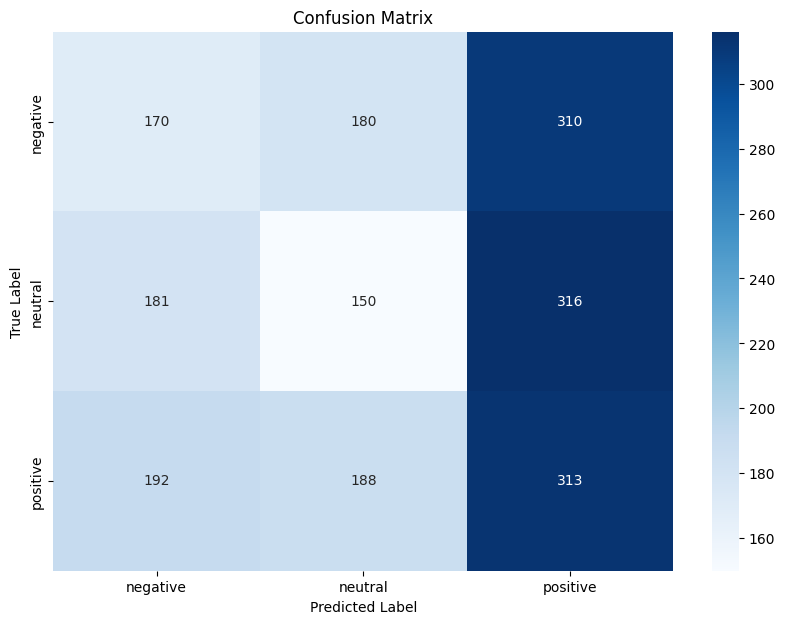

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()